Main reference here - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
plt.ion()

In [4]:
dataset_root = "/Users/shawon/Codes/Python/V6"
dataset_path = os.path.join(dataset_root, "train")

In [11]:
# load all image names and their labels
dataset_info = [] # (label, file_name) tuple

In [9]:
class_labels = os.listdir(dataset_path)
class_labels.pop(class_labels.index('.DS_Store'))
class_labels

['fresh_mango',
 'rotten_mango',
 'fresh_apple',
 'fresh_banana',
 'rotten_apple',
 'rotten_orange',
 'rotten_banana',
 'fresh_orange']

In [12]:
for label in class_labels:
    p = os.path.join(dataset_path, label)
    images = os.listdir(p)

    for img in images:
        dataset_info.append((label, os.path.join(p, img)))

In [22]:
# a function to show an image

def show_image(image_path):
    plt.imshow(io.imread(image_path))

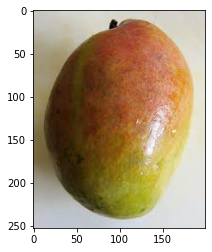

In [23]:
show_image(dataset_info[0][1])
plt.show()

In [20]:
# create torch dataset
class FruitImageDataset(Dataset):
    def __init__(self, dataset_info, transform=None):
        self.dataset_info = dataset_info
        self.transform = transform

    def __len__(self):
        return len(self.dataset_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.dataset_info[idx][0]
        img_file_name = self.dataset_info[idx][1]

        image = io.imread(img_file_name)

        sample = { "label": label, "image": image }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [21]:
fruit_imageset = FruitImageDataset(dataset_info=dataset_info)

0 (253, 200, 3) fresh_mango
1 (240, 360, 3) fresh_mango
2 (204, 247, 3) fresh_mango
3 (200, 200, 3) fresh_mango


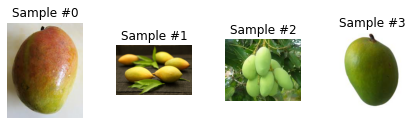

In [28]:
fig = plt.figure()

for i in range(len(fruit_imageset)):
    sample = fruit_imageset[i]

    print(i, sample["image"].shape, sample["label"])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")

    plt.imshow(sample["image"])

    if i == 3:
        plt.show()
        break

In [51]:
# transorms

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["image"], sample["label"]

        img = transform.resize(image, self.output_size)

        return { "label": label, "image": img }

In [41]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}

In [62]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}

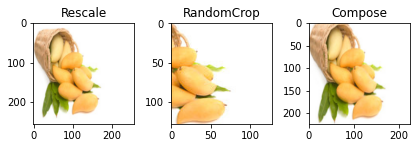

In [63]:
scale = Rescale((256, 256))
crop = RandomCrop((128, 128))

composed = transforms.Compose([Rescale((256, 256)),
                               RandomCrop((224, 224))])

fig = plt.figure()
sample = fruit_imageset[5]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    
    plt.imshow(transformed_sample["image"])

plt.show()

In [64]:
transformed_dataset = FruitImageDataset(dataset_info=dataset_info, 
                                        transform=transforms.Compose([Rescale((256, 256)),
                                                                        RandomCrop((224, 224)), ToTensor()]))

In [65]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["label"])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) fresh_mango
1 torch.Size([3, 224, 224]) fresh_mango
2 torch.Size([3, 224, 224]) fresh_mango
3 torch.Size([3, 224, 224]) fresh_mango


In [66]:
# use a dataloader
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

0 torch.Size([4, 3, 224, 224]) ['rotten_apple', 'fresh_mango', 'rotten_banana', 'fresh_mango']
1 torch.Size([4, 3, 224, 224]) ['fresh_banana', 'rotten_apple', 'fresh_mango', 'fresh_orange']
2 torch.Size([4, 3, 224, 224]) ['fresh_banana', 'rotten_apple', 'rotten_mango', 'fresh_banana']
3 torch.Size([4, 3, 224, 224]) ['fresh_banana', 'rotten_banana', 'rotten_banana', 'fresh_mango']


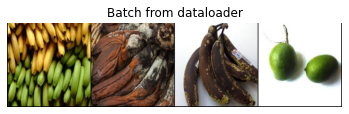

In [69]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, label_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched["label"])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
